In [1]:
from env.env_v1 import SpatialSpreadEnv
import os
from copy import deepcopy
import numpy as np
import supersuit as ss
import torch
from tqdm import trange

from agilerl.algorithms.core.registry import HyperparameterConfig, RLParameter
from agilerl.algorithms.maddpg import MADDPG
from agilerl.components.multi_agent_replay_buffer import MultiAgentReplayBuffer
from agilerl.utils.utils import create_population, observation_space_channels_to_first
from agilerl.vector.pz_async_vec_env import AsyncPettingZooVecEnv

/home/duke1213/miniconda3/envs/epi/lib/python3.11/site-packages/accelerate/utils/torch_xla.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


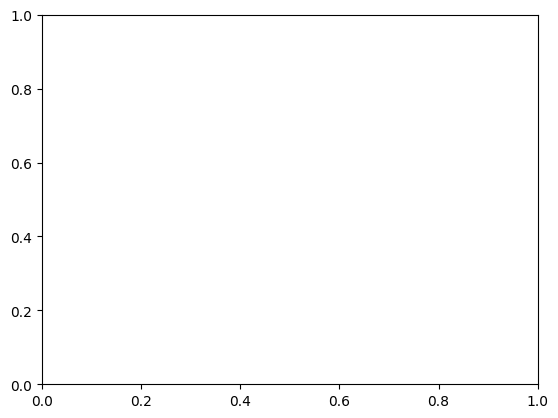

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NET_CONFIG = {
  "encoder_config": {'hidden_size': [32, 32]}, 
  "head_config": {'hidden_size': [32]}     
}
INIT_HP = {
    "POPULATION_SIZE": 1,
    "ALGO": "MADDPG",
    "CHANNELS_LAST": False,
    "BATCH_SIZE": 64,
    "O_U_NOISE": True,
    "EXPL_NOISE": 0.1,
    "MEAN_NOISE": 0.0,
    "THETA": 0.15,
    "DT": 0.01,
    "LR_ACTOR": 0.0005,
    "LR_CRITIC": 0.0005,
    "GAMMA": 0.95,
    "MEMORY_SIZE": 200000,
    "LEARN_STEP": 100,
    "TAU": 0.01,
}
num_envs = 8
env  = SpatialSpreadEnv()
env = AsyncPettingZooVecEnv([lambda: env for _ in range(num_envs)])
env.reset()
observation_spaces = [env.single_observation_space(agent) for agent in env.agents]
action_spaces = [env.single_action_space(agent) for agent in env.agents]
INIT_HP["AGENT_IDS"] = env.agents
hp_config = HyperparameterConfig(
    lr_actor=RLParameter(min=1e-4, max=1e-2),
    lr_critic=RLParameter(min=1e-4, max=1e-2),
    batch_size=RLParameter(min=16, max=128, dtype=int),
    learn_step=RLParameter(min=50, max=200, dtype=int, grow_factor=1.5, shrink_factor=0.75),
)
agent: MADDPG = create_population(
    INIT_HP["ALGO"],
    observation_spaces,
    action_spaces,
    NET_CONFIG,
    INIT_HP,
    hp_config,
    population_size=INIT_HP["POPULATION_SIZE"],
    num_envs=num_envs,
    device=device,
)[0]
field_names = ["obs", "action", "reward", "next_obs", "done"]
memory = MultiAgentReplayBuffer(
    INIT_HP["MEMORY_SIZE"],
    field_names=field_names,
    agent_ids=INIT_HP["AGENT_IDS"],
    device=device,
)
agent_ids = deepcopy(env.agents)
max_steps = 40000
learning_delay = 500
training_steps = 10000
eval_steps = None
eval_loop = 1
total_steps = 0

In [3]:
print("Training...")
pbar = trange(max_steps, unit="step")
evaluated = True # save time
while np.less(agent.steps[-1], max_steps):
    obs, info = env.reset()
    scores = np.zeros((num_envs, len(agent_ids))) ## solved
    completed_episode_scores = []
    steps = 0

    for idx_step in range(training_steps // num_envs):
        cont_actions, discrete_action = agent.get_action(obs=obs, training=True, infos=info)
        action = discrete_action if agent.discrete_actions else cont_actions
        # action = {agent: env.action_space(agent).sample() for agent in env.agents}
        next_obs, reward, termination, truncation, info = env.step(action)
        if not truncation:
            assert False
        
        # Update scores; here we assume rewards are in dicts ordered by env
        scores += np.array(list(reward.values())).reshape(num_envs, len(agent_ids))
        total_steps += num_envs
        steps += num_envs

        memory.save_to_memory(obs, cont_actions, reward, next_obs, truncation, is_vectorised=True) ## termination

        if memory.counter > learning_delay and len(memory) >= agent.batch_size:
            if agent.learn_step > num_envs:
                learn_step = agent.learn_step // num_envs
                if idx_step % learn_step == 0:
                    experiences = memory.sample(agent.batch_size)
                    agent.learn(experiences)
            else:
                for _ in range(num_envs // agent.learn_step):
                    experiences = memory.sample(agent.batch_size)
                    agent.learn(experiences)

        obs = next_obs

        reset_noise_indices = []
        term_array = np.array(list(termination.values())).transpose()
        trunc_array = np.array(list(truncation.values())).transpose()
        for idx, (d, t) in enumerate(zip(term_array, trunc_array)):
            if np.any(d) or np.any(t):
                completed_episode_scores.append(scores[idx])
                agent.scores.append(scores[idx])
                scores[idx] = 0
                reset_noise_indices.append(idx)
        agent.reset_action_noise(reset_noise_indices)

    pbar.update(training_steps)
    agent.steps[-1] += steps

    if not evaluated:
        fitness = agent.test(
            env,
            swap_channels=False,
            max_steps=eval_steps,
            loop=eval_loop,
            sum_scores=False,
        )
        pop_episode_scores = np.array(completed_episode_scores)
        mean_scores = np.mean(pop_episode_scores, axis=0)
        print("--- Global steps {} ---".format(total_steps))
        print("Scores:")
        for idx, sub_agent in enumerate(agent_ids):
            print("    {} score: {}".format(sub_agent, mean_scores[idx]))
        print("Fitness:")
        for idx, sub_agent in enumerate(agent_ids):
            print("    {} fitness: {}".format(sub_agent, fitness[idx]))
        evaluated = True
    agent.steps.append(agent.steps[-1])

path = "./models/MADDPG"
filename = "MADDPG_trained_agent.pt"
os.makedirs(path, exist_ok=True)
save_path = os.path.join(path, filename)
agent.save_checkpoint(save_path)
pbar.close()
env.close()

Training...


100%|███████████████████████████████████████████████████████████████| 40000/40000 [46:37<00:00, 14.30step/s]
